### Unsupervised Learning: PCA and KMeans clustering
#### How to derive a strategy to reduce the incidence of road accidents across the nation?

### variables: 
1. drvr_fatl_col_bmiles = Number of drivers involved in fatal collisions per billion miles (2011)
2. perc_fatl_speed = Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)
3. perc_fatl_alcohol = Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired (2011)
4. perc_fatl_1st_time = Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents (2011)

Source: 1. https://github.com/fivethirtyeight/data/tree/master/bad-drivers
2.https://creativecommons.org/licenses/by/4.0/

In [119]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [120]:
# Read the input csv file
input_filepath = 'datasets/'
input_filename = 'road-accidents.csv'
car_accident = pd.read_csv(input_filepath + input_filename, comment='#', sep='|')

# rename the columns for easier reading
car_accident = car_accident.rename(columns={'drvr_fatl_col_bmiles' : 'drivers_involved_accidents', 
                                            'perc_fatl_speed' : 'speeding', 
                                            'perc_fatl_alcohol' : 'alcohol_impaired',
                                            'perc_fatl_1st_time' : 'first_timer'})

# Display the first five rows of the DataFrame
display(car_accident.head())

# Generate an overview of the DataFrame
print(car_accident.info())

display(car_accident.describe())

,state,drivers_involved_accidents,speeding,alcohol_impaired,first_timer
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12.0,35,28,89


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   state                       51 non-null     object 
 1   drivers_involved_accidents  51 non-null     float64
 2   speeding                    51 non-null     int64  
 3   alcohol_impaired            51 non-null     int64  
 4   first_timer                 51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB
None


,drivers_involved_accidents,speeding,alcohol_impaired,first_timer
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


### Exploratory data analysis (EDA)
#### 1. scatterplot and distribution

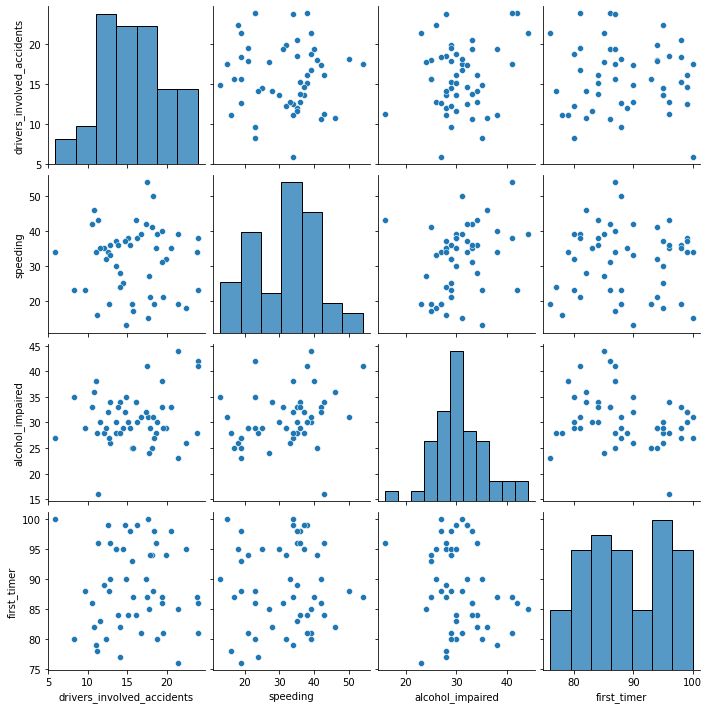

In [121]:
# Create a pairwise scatter plot to explore the data
sns.pairplot(car_accident)

From the above scatterplot it's hard to explain the correlation between the variables.

#### 2. Correlation 

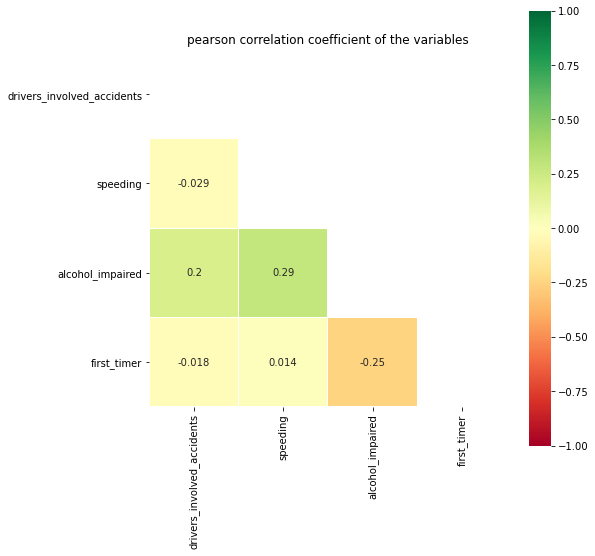

In [122]:
def correlation_plot(df, method):
    """ determines the Pearson, Spearman and Kendall correlation coefficients
    and generates the heatmaps
    Args:
        df (dataframe): 
        method (str): {‘pearson’, ‘kendall’, ‘spearman’}
    Returns:
        heatmap
    """
    plt.figure(figsize=(8, 8))
    plt.title(method + ' correlation coefficient of the variables')

    # find the correlation coefficients
    correlation_matrix = df.corr(method=method)

    # create a mask to remove the upper triangular values
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask)] = True

    # create the heatmap of the correlation coefficients
    sns.heatmap(correlation_matrix, linewidth=0.1, vmax=1.0, vmin=-1.0,
                square=True, cmap='RdYlGn', linecolor='white', annot=True, mask=mask)

    # display the heatmaps
    plt.show()
    
correlation_plot(car_accident, 'pearson')

From the correlation plot, 
1. the number of drivers involved in fatal accidents is positively correlated with alcohol consumption. 
2. speeding and alcohol consumption are positively correlated. 

#### 3. Check the Linear regression coefficients

In [123]:
# Create the features and target DataFrames
features = ['speeding', 'alcohol_impaired','first_timer']
target = 'drivers_involved_accidents'

X = car_accident[features]
y = car_accident[target]

# Create a linear regression object
LR = LinearRegression()

# Fit a multivariate linear regression model
LR = LR.fit(X, y)

# Retrieve the regression coefficients
LR_coefficients = pd.DataFrame({'features': features, 'coefficients': LR.coef_})
LR_coefficients = LR_coefficients.set_index('features')
display(LR_coefficients)

,coefficients
features,
speeding,-0.041800
alcohol_impaired,0.190864
first_timer,0.024733


Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.

We found that alcohol consumption is weakly associated with the number of fatal accidents across states. This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents. But there are also associations between  alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.

#### 4. Principal Component Analysis (PCA)
One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale. We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.

The cumulative variance of the first two principal components is 0.7947


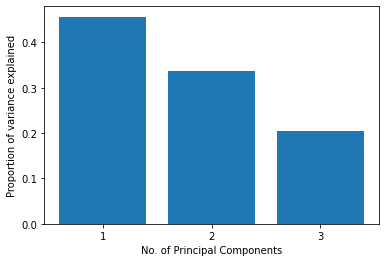

In [124]:
# Standardize and center the feature columns
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

def pca_barplot(scaled_data):
    # Instantiate the PCA class
    pca = PCA()

    # Fit the standardized data to the pca
    pca.fit(scaled_data)
    
    # importance of first 2 principal components
    two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[1]
    print("The cumulative variance of the first two principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

    # Plot the proportion of variance explained on the y-axis of the bar plot
    plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
    plt.xlabel('No. of Principal Components')
    plt.ylabel('Proportion of variance explained')
    plt.xticks([1, 2, 3])
    plt.show()
    
pca_barplot(features_scaled)


The first two principal components enable visualization of the data in two dimensions while capturing a high proportion of the variation (79%) from all three features: speeding, alcohol influence, and first-time accidents. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. 

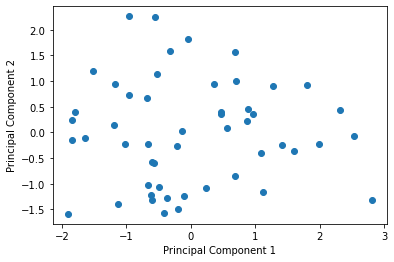

In [125]:
def pca_scatterplot(scaled_data):
    # Transform the scaled features using two principal components
    pca = PCA(n_components=2)
    p_comps = pca.fit_transform(scaled_data)
    
    # Extract the first and second component to use for the scatter plot
    p_comp1 = p_comps[:, 0]
    p_comp2 = p_comps[:, 1]

    # Plot the first two principal components in a scatter plot
    _ = plt.scatter(p_comp1, p_comp2)
    _ = plt.xlabel('Principal Component 1')
    _ = plt.ylabel('Principal Component 2')
    _ = plt.show()
    
    return _, p_comp1, p_comp2

_, p_comp1, p_comp2 = pca_scatterplot(features_scaled)

It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.

#### K-Means clustering

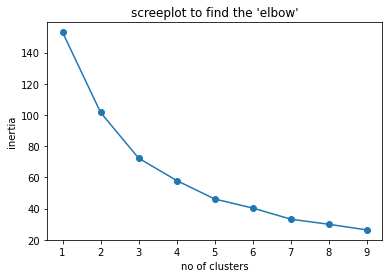

In [126]:
def screeplot(scaled_data, num_of_clusters):
    # A loop will be used to plot the explanatory power for up to 10 KMeans clusters
    inertias = []

    for k in num_of_clusters:
        # Initialize the KMeans object using the current number of clusters (k)
        km = KMeans(n_clusters=k, random_state=1)

        # Fit the scaled features to the KMeans object
        km.fit(scaled_data)

        # Append the inertia for 'km' to the list of inertias
        inertias.append(km.inertia_)

    # Plot the results in a line plot
    plt.plot(num_of_clusters, inertias, marker='o')
    plt.xlabel("no of clusters")
    plt.ylabel("inertia")
    plt.title("screeplot to find the 'elbow'")
    plt.show()
    
screeplot(features_scaled, range(1,10))

Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters. Let's see how the PCA scatter plot looks if we color the states according to the cluster to which they are assigned.

#### KMeans to visualize clusters in the PCA scatter plot

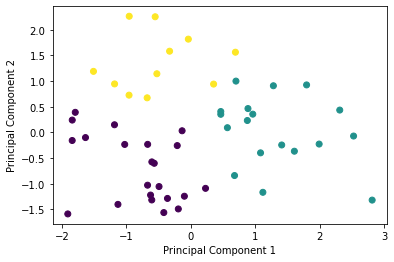

In [127]:
# Create a KMeans object with 3 clusters, use random_state=1
km = KMeans(n_clusters=3, random_state=1)

# Fit the data to the `km` object
km.fit(features_scaled)

# Create a scatter plot of the first two principal components
# and color it according to the KMeans cluster assignment 
plt.scatter(p_comp1, p_comp2, c=km.labels_)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Check the data with the KMeans label

In [128]:
# Create a new column with the labels from the KMeans clustering
car_accident['cluster'] = km.labels_

display(car_accident[car_accident['cluster'] == 0].head(3))
display(car_accident[car_accident['cluster'] == 1].head(3))
display(car_accident[car_accident['cluster'] == 2].head(3))

,state,drivers_involved_accidents,speeding,alcohol_impaired,first_timer,cluster
1,Alaska,18.1,41,25,94,0
2,Arizona,18.6,35,28,96,0
3,Arkansas,22.4,18,26,95,0


,state,drivers_involved_accidents,speeding,alcohol_impaired,first_timer,cluster
0,Alabama,18.8,39,30,80,1
6,Connecticut,10.8,46,36,82,1
11,Hawaii,17.5,54,41,87,1


,state,drivers_involved_accidents,speeding,alcohol_impaired,first_timer,cluster
15,Iowa,15.7,17,25,87,2
16,Kansas,17.8,27,24,85,2
17,Kentucky,21.4,19,23,76,2


Thus far, we have used both our visual interpretation of the data and the KMeans clustering algorithm to reveal patterns in the data, but what do these patterns mean?

Remember that the information we have used to cluster the states into three distinct groups are the percentage of drivers speeding, under alcohol influence and that has not previously been involved in an accident. We used these clusters to visualize how the states group together when considering the first two principal components. This is good for us to understand structure in the data, but it's not easy to understand.

#### How the three clusters are different in terms of the three features that we used for clustering?

,cluster,measurement,percent
0,1,speeding,39
1,0,speeding,41
2,0,speeding,35
3,0,speeding,18
4,0,speeding,35


<AxesSubplot:xlabel='percent', ylabel='measurement'>

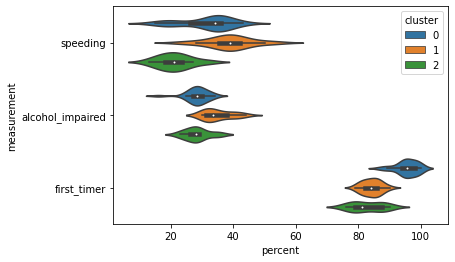

In [129]:
# Reshape the DataFrame to the long format using the actual data
melted_car_accident = pd.melt(car_accident, 
                            id_vars="cluster", 
                            var_name="measurement", 
                            value_name="percent", 
                            value_vars=X)

display(melted_car_accident.head())

# Create a violin plot splitting and coloring the results according to the km-clusters
sns.violinplot(x=melted_car_accident["percent"], 
               y=melted_car_accident["measurement"], 
               hue=melted_car_accident["cluster"])

There is still no obvious correct choice regarding which cluster is the most important to focus on! Need more features and further analysis